# Predicting Boston Housing Prices
## Model Evaluation & Validation
## John Kinstler
### Project files at https://github.com/m00nd00r/Boston-Housing

### Install
This project requires **Python 2.7** and the following Python libraries installed:

- [NumPy](http://www.numpy.org/)
- [Pandas](http://pandas.pydata.org/)
- [matplotlib](http://matplotlib.org/)
- [scikit-learn](http://scikit-learn.org/stable/)
- [requests](http://docs.python-requests.org/en/master/)

You will also need to have software installed to run and execute a [Jupyter Notebook](http://ipython.org/notebook.html)

If you do not have Python installed yet, it is highly recommended that you install the [Anaconda](http://continuum.io/downloads) distribution of Python, which already has the above packages and more included.

## Acquire The Data

This project evaluates the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a good fit could then be used to make certain predictions about a home — in particular, its monetary value. 

The dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/), which is archived from the **UCI Machine Learning Repository**. This project evaluates several machine learning algorithms for their performance in predicting housing prices for data taken from the Boston Area.

The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. 

For our purposes, we're going to assume that the 'MEDV' price was taken in Janurary, 1978. We're going to use the housing price index data for Boston from [FRED](https://fred.stlouisfed.org/series/ATNHPIUS14454Q) to translate 1978 Boston home prices into 2017 prices. Since the data are indices, we simply multiply the value of 'MEDV' by the index for today (the last value in the data set), then divide that by the index value from January, 1978. This will give us the home value adjusted for today's dollars.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load the Boston housing dataset
urlnames = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names"
rnames = requests.get(urlnames).content
table = pd.read_table(urlnames, header=None, squeeze=True)
names = table[22:39].str.extract('([A-Z]+)', expand=False).dropna()

urldata = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
rdata = requests.get(urldata).content
data = pd.read_csv(io.StringIO(rdata.decode('utf-8')), delim_whitespace=True, header=None, names=names.values)

attributes = rnames.strip().splitlines()
attributes = attributes[attributes.index('7. Attribute Information:'):-1]

# Load housing price index data
urlhpi = 'https://fred.stlouisfed.org/graph/fredgraph.csv?chart_type=line&recession_bars=on&log_scales=&bgcolor=%23e1e9f0&graph_bgcolor=%23ffffff&fo=Open+Sans&ts=12&tts=12&txtcolor=%23444444&show_legend=yes&show_axis_titles=yes&drp=0&cosd=1977-10-01&coed=2017-04-01&height=450&stacking=&range=&mode=fred&id=ATNHPIUS14454Q&transformation=lin&nd=1977-10-01&ost=-99999&oet=99999&lsv=&lev=&mma=0&fml=a&fgst=lin&fgsnd=2009-06-01&fq=Quarterly&fam=avg&vintage_date=&revision_date=&line_color=%234572a7&line_style=solid&lw=2&scale=left&mark_type=none&mw=2&width=1168'
atnhpi = pd.read_csv(urlhpi)

# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Boston housing dataset has 506 data points with 14 variables each.


In [2]:
attributes

['7. Attribute Information:',
 '',
 '    1. CRIM      per capita crime rate by town',
 '    2. ZN        proportion of residential land zoned for lots over ',
 '                 25,000 sq.ft.',
 '    3. INDUS     proportion of non-retail business acres per town',
 '    4. CHAS      Charles River dummy variable (= 1 if tract bounds ',
 '                 river; 0 otherwise)',
 '    5. NOX       nitric oxides concentration (parts per 10 million)',
 '    6. RM        average number of rooms per dwelling',
 '    7. AGE       proportion of owner-occupied units built prior to 1940',
 '    8. DIS       weighted distances to five Boston employment centres',
 '    9. RAD       index of accessibility to radial highways',
 '    10. TAX      full-value property-tax rate per $10,000',
 '    11. PTRATIO  pupil-teacher ratio by town',
 '    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks ',
 '                 by town',
 '    13. LSTAT    % lower status of the population',
 "    14.

In [3]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
atnhpi.head()

,DATE,ATNHPIUS14454Q
0,1977-10-01,25.09
1,1978-01-01,24.83
2,1978-04-01,26.61
3,1978-07-01,30.04
4,1978-10-01,29.88


## Pre-process
Since the goal of this project is to construct a model to predict the value of homes in the Boston area, we need to separate the dataset into features and the target variable. We're going to use the feature 'MEDV' as the target for the home prices. This feature is represented in 1000's - so each value is 1/1000th the actual price. However, these prices were recorded in 1978, so we'd like update the prices for those homes in today's dollars. Since we've already created this data frame, let's have a look at it.

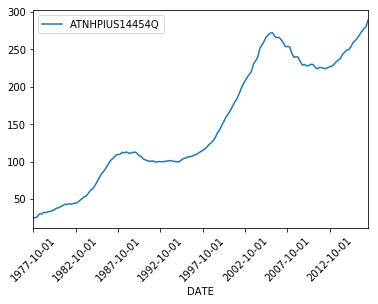

In [5]:
atnhpi.plot(x='DATE', rot=45);

We can see that history of home prices since the last 70's for the Boston area above. The nice thing about this data is that since it's index we can easily update our 1978 home prices to 2017 prices by multiplying the 1978 price by the last available index and dividing by the index value for the year our data was collected.

So, let's do that.

In [2]:
index = atnhpi[atnhpi['DATE']=='1978-01-01'].index[0]
index

1

In [3]:
data['MEDV-ATNHPI'] = np.nan
data['MEDV-ATNHPI'] = data['MEDV']*atnhpi.ATNHPIUS14454Q.iloc[-1]/atnhpi.ATNHPIUS14454Q.iloc[index]

In [4]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,MEDV-ATNHPI
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0,279.484495
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6,251.536045
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7,404.087998
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4,388.949255
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2,421.555779


Let's split this data set into a features set and a target set.

In [2]:
prices = data['MEDV']
features = data.drop(['MEDV'], axis = 1)

In [5]:
prices = data['MEDV-ATNHPI']
features = data.drop(['MEDV', 'MEDV-ATNHPI'], axis = 1)

In [10]:
features

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10


In [5]:
prices.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64

## Data Exploration


The next thing to do is to look at some statistics about this data. We want to know which of these features will actually be useful in predictin the target. The idea here is that want to identify the features that are most correlated to the target, which is the home price. However, we don't want features that are highly correlated to each other - these features wind up being redundant, or worse, will reduce the predictor's ability to learn the target.

In [6]:
features.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Just from the above we can see that the means of many of these features are much closer to the max or min values, which means there's a lot of skewness. Others are sort of behaving like categorical features even though they're not and still others appear to be clumping around certain values.

Let's visualize this.

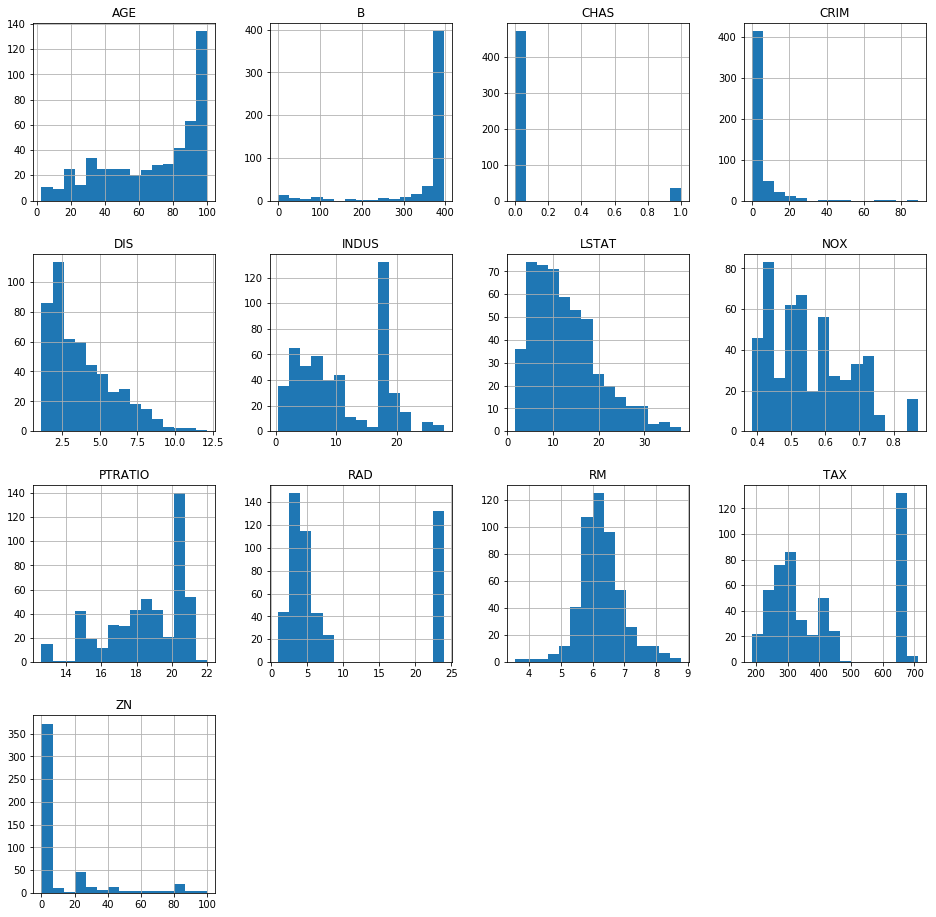

In [3]:
features.hist(bins=15, figsize=(16,16));

Alright, many of these features are crying out to be tranformed a bit or otherwise just discarded. Just from above, it looks like AGE, DIS, LSTAT, NOX, and RM have fairly happy looking Gaussian distributions with RM (average number of rooms) looking about as perfect as we could hope for. The others will need to be centered or logged, depending on the outcome of further investigation.

The rest of them look odd at best and, frankly, not very helpful. The exceptions might be B, CRIM, and possibly PTRATIO. We'll have to see how well they perform.

However, another possibility would be to use the Decision Tree Regressor, which is robust to varying feature scales.

To get quality regressions, we ideally want our features to be independent and identically distributed, but also highly correlated with our dependent variable, the prices. This means we want our independent variables to not be influenced by any of the other independent variables. In reality, this isn't alwasy the case and we may have to live with it. However, we can still try to get to this end as best as we can. Further, we want to select independent variable that will predict our dependent variable very well, so we want to see high correlation between these.

A tidy and very powerful to visualize all fo this is to create a pair-wise scatter matrix plot of every feature against every other feature. This will help us quickly see which features are independent of each other and which are not. It will also help us see which are have good correlation with housing prices.

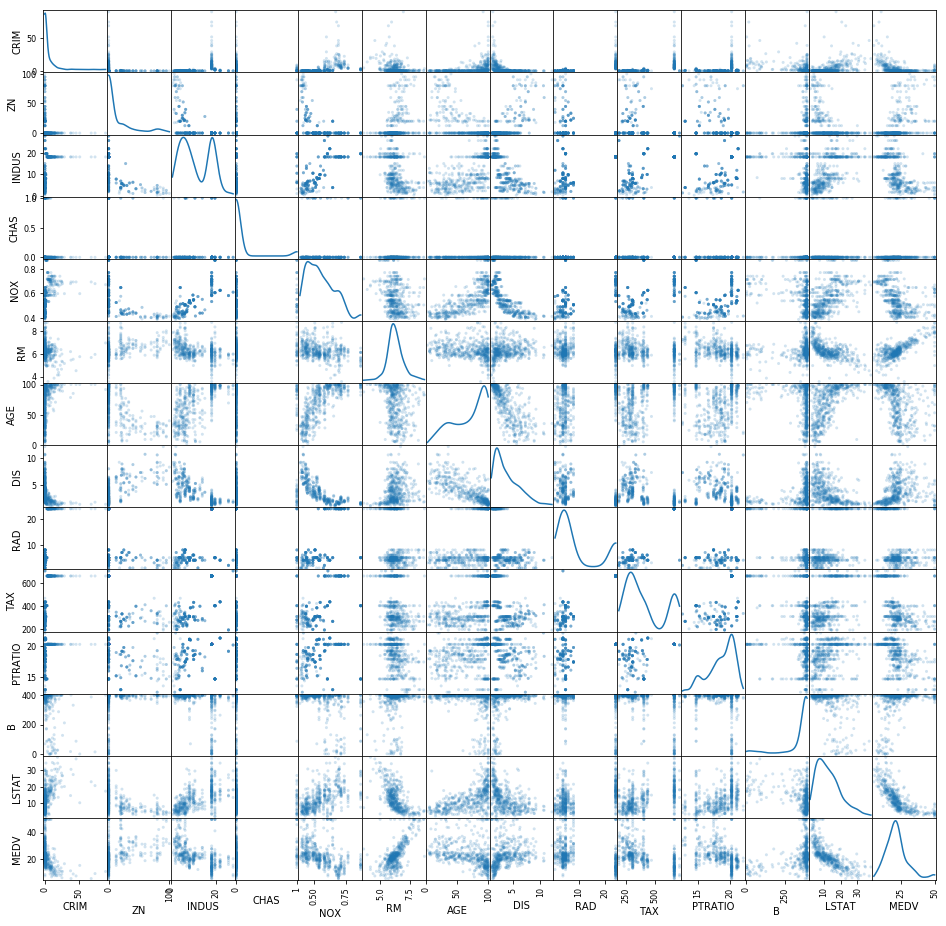

In [8]:
scatter_matrix(data, alpha=0.2, figsize=(16, 16), diagonal='kde');

From the above scatter matrix we can quickly see that some of these features are better than others. Case in point the feature 'RM' (average number of rooms) is just about perfectly correlated with the price, indicated by the tightness of the data points to an imaginary line starting from the lower left of the plot and increasing toward the upper right area, which is exactly what we would expect - more rooms in the houses equal higher prices. However, there appears to be some negative correlation with 'LSTAT'. Outside of that 'RM' looks to be fairly independent of the rest. This is what we would like to see of good features: high correlation with the dependent variable (house prices) and lack of correlation with (independent of) the rest of the features.

Not so with 'DIS' (weight distance to 5 Boston employment centers). It looks to be correlated with all except 'RAD', 'TAX', and 'PTRATIO'.

'INDUS', 'RAD', and 'TAX' are strongly bimodal. None of them appears to have any obvious correlation with price, however, so we may decide to discard them altogether. However, it may worth attempting to transform the data to try to normalize it

'B', 'CRIM', and 'ZN' are all highly skewed which will need to be logged, or something else, to normalize these features.

'NOX', 'AGE', and 'PTRATION' all look to need to be rescaled.

The drawback of the above pairplot is that it's too subjective. Let's get some actual numbers to quantify these correlations.

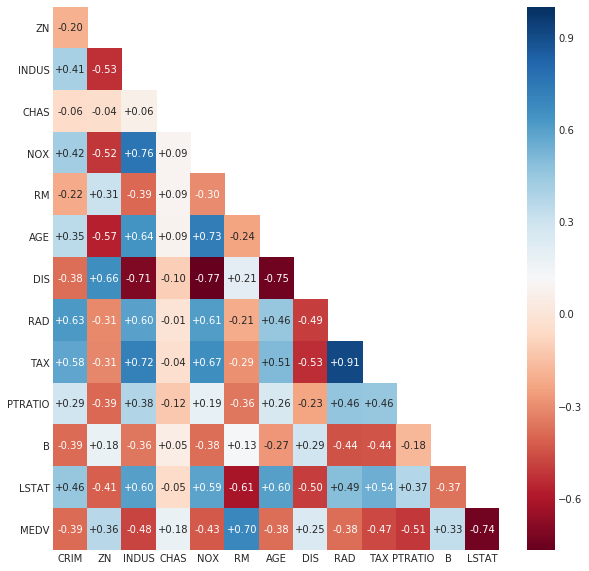

In [7]:
# get the feature correlations
corr = data.corr()

# remove first row and last column for a cleaner look
corr.drop(['CRIM'], axis=0, inplace=True)
corr.drop(['MEDV'], axis=1, inplace=True)

# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

plt.figure(figsize=(10,10))
# plot the heatmap
with sns.axes_style("white"):
    g = sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu', fmt='+.2f', cbar=True)
    g.set_yticklabels(g.get_yticklabels(), rotation=0)

The heatmap above confirms what we saw in pairplot: high negative correlation between price and percent of low income residents(LSTAT), high positive correlation between price and number of rooms in the house(RM), with some potentially useful negative correlations with student/teacher ratios(PTRATIO), taxes(TAX), and number of industrial business in the neighborhood(INDUS).

We can also see quite a lot of dark reds and blues in the rest of the map indicating lots of high levels of correlation among the features. Without having done any data transformations yet, we can already see the need for some dimensionality reduction or feature extraction.

To begin this process let's look more closely at the home prices data.

Below, we can see that there's an odd little tail of housing prices that spike at the high end of the distribution. We definitely want to see what's happening there.

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

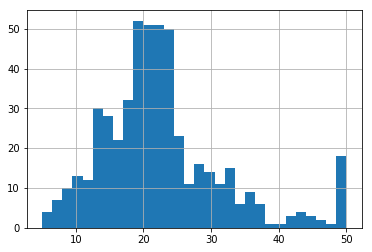

In [8]:
prices.hist(bins=30);prices.describe()

As can be seen above from the unadjusted prices that there is a group of max value prices at 50 thousand dollars. Let's look at these housing groups to see their features.

In [3]:
#highmedv = data[data['MEDV']==50.0].drop(['MEDV'], axis=1)
highmedv = features[prices==50.0]
highmedv

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
161,1.46336,0.0,19.58,0,0.6050,7.489,90.8,1.9709,5,403.0,14.7,374.43,1.73
162,1.83377,0.0,19.58,1,0.6050,7.802,98.2,2.0407,5,403.0,14.7,389.61,1.92
163,1.51902,0.0,19.58,1,0.6050,8.375,93.9,2.1620,5,403.0,14.7,388.45,3.32
166,2.01019,0.0,19.58,0,0.6050,7.929,96.2,2.0459,5,403.0,14.7,369.30,3.70
186,0.05602,0.0,2.46,0,0.4880,7.831,53.6,3.1992,3,193.0,17.8,392.63,4.45
195,0.01381,80.0,0.46,0,0.4220,7.875,32.0,5.6484,4,255.0,14.4,394.23,2.97
204,0.02009,95.0,2.68,0,0.4161,8.034,31.9,5.1180,4,224.0,14.7,390.55,2.88
225,0.52693,0.0,6.20,0,0.5040,8.725,83.0,2.8944,8,307.0,17.4,382.00,4.63
257,0.61154,20.0,3.97,0,0.6470,8.704,86.9,1.8010,5,264.0,13.0,389.70,5.12
267,0.57834,20.0,3.97,0,0.5750,8.297,67.0,2.4216,5,264.0,13.0,384.54,7.44


So, there's 16 neighborhoods here with the highest average home prices of the entire dataset, which don't appear to fit the distribution for the rest of the data. If they're outliers, we'd expect to see far fewer, representing a much smaller subset of our sample. If they indicate a bimodal distribution, we'd expect to say more fall off in the prices on either side of the maximum.

However, this spike in quantity at this specific value suggests a relationship that's not properly represented in the feature and sample space or is  improperly collected or recorded data, i.e. NaNs with 50.0s imputed.

The question is whether any of these could actually be legitimate data points? Intuitively, we might expect to see higher value homes to be larger(ZN) with more rooms(RM), maybe a bit newer(AGE), in neighborhoods with smaller student/teacher ratios(PTRATIO), and in neighborhoods with less industrial acreage(INDUS), low crime(CRIM), and less low income people(LSTAT).

Based on these criteria, we can quickly identify 5 data points that fit based on the feature ZN alone. From the historgram above, this number of data points would appear to be more consistent with the overall distribution.

In [4]:
highmedv1 = features[(prices==50.0) & (features['ZN']==0.0)]
highmedv1

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
161,1.46336,0.0,19.58,0,0.605,7.489,90.8,1.9709,5,403.0,14.7,374.43,1.73
162,1.83377,0.0,19.58,1,0.605,7.802,98.2,2.0407,5,403.0,14.7,389.61,1.92
163,1.51902,0.0,19.58,1,0.605,8.375,93.9,2.1620,5,403.0,14.7,388.45,3.32
166,2.01019,0.0,19.58,0,0.605,7.929,96.2,2.0459,5,403.0,14.7,369.30,3.70
186,0.05602,0.0,2.46,0,0.488,7.831,53.6,3.1992,3,193.0,17.8,392.63,4.45
225,0.52693,0.0,6.20,0,0.504,8.725,83.0,2.8944,8,307.0,17.4,382.00,4.63
368,4.89822,0.0,18.10,0,0.631,4.970,100.0,1.3325,24,666.0,20.2,375.52,3.26
369,5.66998,0.0,18.10,1,0.631,6.683,96.8,1.3567,24,666.0,20.2,375.33,3.73
370,6.53876,0.0,18.10,1,0.631,7.016,97.5,1.2024,24,666.0,20.2,392.05,2.96
371,9.23230,0.0,18.10,0,0.631,6.216,100.0,1.1691,24,666.0,20.2,366.15,9.53


Now, let's remove these and see how the correlations compare to the previous.

In [3]:
nohighmedvdata1 = data[~(data['MEDV']==50.0) | ~(data['ZN']==0.0)].reset_index(drop=True)
nohighmedvdata1.shape

(495, 14)

Now, let's also create another dataset with none of the high value prices at all, just for to compare

In [4]:
nohighmedvdata2 = data[~(data['MEDV']==50.0)].reset_index(drop=True)
nohighmedvdata2.shape

(490, 14)

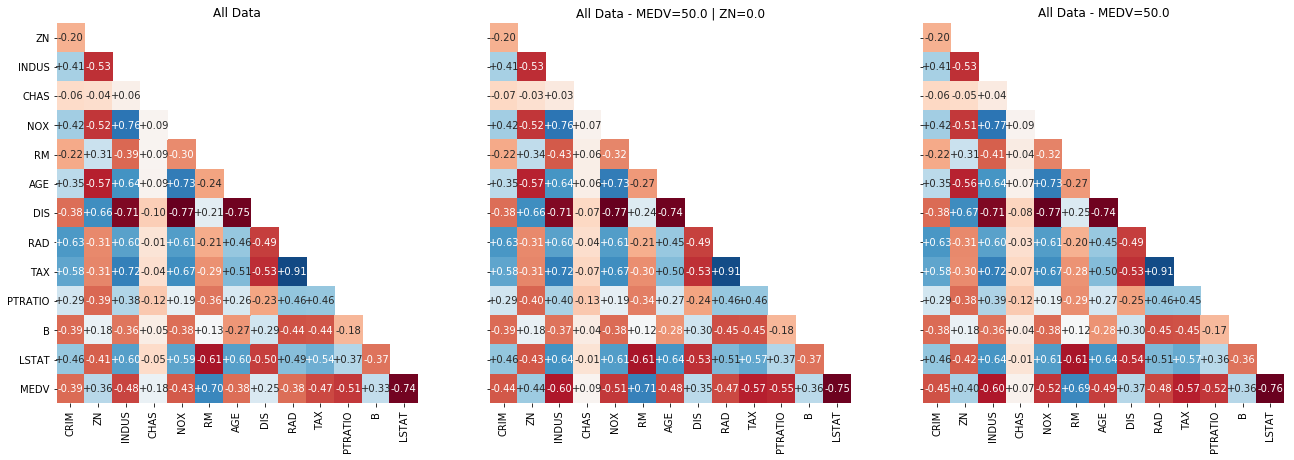

In [80]:
# get the feature correlations
corr = data.corr()
corr1 = nohighmedvdata1.corr()
corr2 = nohighmedvdata2.corr()

# remove first row and last column for a cleaner look
corr.drop(['CRIM'], axis=0, inplace=True)
corr.drop(['MEDV'], axis=1, inplace=True)
corr1.drop(['CRIM'], axis=0, inplace=True)
corr1.drop(['MEDV'], axis=1, inplace=True)
corr2.drop(['CRIM'], axis=0, inplace=True)
corr2.drop(['MEDV'], axis=1, inplace=True)

# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
mask1 = np.zeros_like(corr1)
mask1[np.triu_indices_from(mask1, 1)] = True
mask2 = np.zeros_like(corr2)
mask2[np.triu_indices_from(mask2, 1)] = True

f, (a,a1,a2) = plt.subplots(1,3, sharey=False, figsize=(22,7))
# plot the heatmap
with sns.axes_style("white"):
    #sns.set_context(font_scale=.9)
    g = sns.heatmap(corr, mask=mask1, annot=True, cmap='RdBu', fmt='+.2f', cbar=False, ax=a)
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    a.set_title('All Data')
    g1 = sns.heatmap(corr1, mask=mask2, annot=True, cmap='RdBu', fmt='+.2f', cbar=False, ax=a1)
    g1.set(yticklabels=[])
    a1.set_title('All Data - MEDV=50.0 | ZN=0.0')
    g2 = sns.heatmap(corr2, mask=mask2, annot=True, cmap='RdBu', fmt='+.2f', cbar=False, ax=a2)
    g2.set(yticklabels=[])
    a2.set_title('All Data - MEDV=50.0')

Notice from the above, we get substantial improvement from All Data to All Data - MEDV=50.0 | ZN=0.0 (subtracting 10 data points), but not much more when removing all high prices at 50.0 (substracting all 16 points).

In [5]:
features1 = nohighmedvdata1.drop('MEDV', axis=1)
prices1 = nohighmedvdata1['MEDV']

In [6]:
features2 = nohighmedvdata2.drop('MEDV', axis=1)
prices2 = nohighmedvdata2['MEDV']

## Developing a Model

### Implementation: Define a Performance Metric

At this point, we want to start creating some predictors. The goal here is to create a predictor to get a likely average home value for a particular neighborhood in the Boston area. Ultimately we will want to be able to provide our model with a few statistics for the neighborhood and the type of house we want and then get a good estimation as to what kinds of prices we should be expecting to pay.

First we'll need to establish a baseline to judge how well our predictor performs. The easiest thing to do is to just predict the average of all the home prices and use that as our prediction results.

Let's use mean squared error and R2 for scoring our models.

### Implementation: Shuffle and Split the Data

In [101]:
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
import renders as rs
import pprint

In [7]:
def split(feat_data, feat_targs, test_size=0.2):
    # Shuffle and split the data into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(feat_data, feat_targs, test_size = test_size, random_state = 0)
    #X_train1, X_test1, y_train1, y_test1 = train_test_split(features1, prices1, test_size = test_size, random_state = 0)
    #X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, prices2, test_size = test_size, random_state = 0)
    
    return X_train, X_test, y_train, y_test

In [31]:
meanpred = pd.Series(np.mean(y_train), index=y_test.index)
np.mean(y_train), mean_squared_error(y_test, meanpred)

(22.61188118811882, 81.582317439082317)

In [32]:
r2_score(y_test, meanpred)

-0.0018897375285074069

So for an average home price of \$22,612, our baseline mean squared error is 81.6 with slightly negative $R^{2}$, which means that this model has less than no predictive value. However, these are scores for the whole dataset and so that average home price will be a bit high. Let's see these scores for our other 2 datasets.

In [33]:
meanpred1 = pd.Series(np.mean(y_train1), index=y_test1.index)
print(np.mean(y_train1), mean_squared_error(y_test1, meanpred1))
print(r2_score(y_test1, meanpred1))

(22.080808080808062, 58.487315580042818)
-0.010838818876


In [34]:
meanpred2 = pd.Series(np.mean(y_train2), index=y_test2.index)
print(np.mean(y_train2), mean_squared_error(y_test2, meanpred2))
print(r2_score(y_test2, meanpred2))

(21.414795918367354, 78.54502316743023)
-0.0158088027164


We can see with some of the outliers removed we get lower baselines. These will ultimately be the scores our predictors need to beat.

With that established, let's look at how an out of the box Decision Tree Regressor with the \$50,000 prices without 25,000 sq. ft. house zoning.

In [35]:
reg = DecisionTreeRegressor(random_state=0)
reg.fit(X_train1, y_train1)
pred = reg.predict(X_test1)
mean_squared_error(y_test1, pred), reg.score(X_test1, y_test1)

(11.127474747474746, 0.80768336998786894)

In [36]:
reg.fit(X_train2, y_train2)
pred = reg.predict(X_test2)
mean_squared_error(y_test2, pred), reg.score(X_test2, y_test2)

(18.744183673469387, 0.7575848092290256)

An MSE of 19 is terrible on it's own, and obviously bad compared to our baseline. However, the $R^2$ is showing that even though it doesn't predict well at all, it's still matching the underlying variance of the data.

From here we'll need to start improving our data to get better results. The first thing to do is to determine which features will have the greatest predictive value on prices. We've seen above in our histograms, scatterplots, and heatmaps that some features correlate very highly with the average home prices like number of rooms and percent of low income people with another tier the perform fairly well.

Harder to see is just how much each feature can be explained by other features, i.e. how much they correlate with other features. Knowing this will help us rank which features to keep and which to discard.

Let's do this be holding out each feature successively as the target variable and see how well our Decision Tree Regressor can predict each held feature target with the remaining features. Here a high positive $R^2$ score will show high correlation and thus identifty that feature as a good candidate to remove, whereas low positive to high negative scores will show features to keep.

In [185]:
def feature_test(feat_data):
    ''' Test each feature for correlation with the rest of the features. '''
    
    rank_scores = []
    for i in range(len(feat_data.columns)):
        new_features = feat_data.drop(feat_data.columns[i],1)
        new_target = feat_data[feat_data.columns[i]]
    
        # Split the data into training and testing sets using the given feature as the target
        X_train, X_test, y_train, y_test = train_test_split(new_features, new_target, test_size=0.2, random_state=0)
    
        # Create a decision tree regressor and fit it to the training set
        reg = DecisionTreeRegressor(random_state=0)
        clf = reg.fit(X_train,y_train)
    
        # Report the score of the prediction using the testing set
        score = clf.score(X_test,y_test)
        rank_scores.append((feat_data.columns[i], score))
        
    rank_scores = sorted(rank_scores, key=lambda scores: scores[1])
    return rank_scores

In [186]:
pprint.pprint(feature_test(features))
pprint.pprint(feature_test(features1))
pprint.pprint(feature_test(features2))

[('CHAS', -0.3804511278195486),
 ('B', -0.21132218398114455),
 ('RM', 0.23139913620530528),
 ('LSTAT', 0.25128024086755352),
 ('CRIM', 0.31753694556474688),
 ('AGE', 0.6049673288677927),
 ('NOX', 0.82689011431422632),
 ('DIS', 0.87401198064596386),
 ('TAX', 0.9112962700713545),
 ('ZN', 0.93026128373093353),
 ('RAD', 0.94384366271451658),
 ('PTRATIO', 0.95304210417898905),
 ('INDUS', 0.95599465742906564)]
[('CHAS', -0.35989010989010972),
 ('CRIM', -0.023652076743000849),
 ('AGE', 0.30275756100664419),
 ('RM', 0.37962556581402995),
 ('B', 0.40733517644247164),
 ('LSTAT', 0.47362268576566058),
 ('ZN', 0.84532772947974033),
 ('NOX', 0.85836607861320058),
 ('DIS', 0.87163402095614495),
 ('PTRATIO', 0.8986263543226094),
 ('TAX', 0.94960635631662771),
 ('INDUS', 0.97842965136043847),
 ('RAD', 0.98634194846538892)]
[('CHAS', -1.0851063829787235),
 ('B', -0.059448839720307234),
 ('RM', 0.19448151960837734),
 ('CRIM', 0.52787454104531439),
 ('LSTAT', 0.52833980736218078),
 ('AGE', 0.543828762142

We can see from above that the features with the highest positive results are predicted by the other features, which means they are highly correlated to the rest of the features. Those with negative values are uncorrelated and independent features.

The one we see that is consistently the lowest is CHAS (proximity to the Charles River) also happens to be uncorrelated to home price, as seen in the heatmap above. Also the percentage of Black people is independent depending on which data points we include. In fact, we can see that choice of data points to keep can have a powerful effect on our results. This is why we want to careful about which data points to discard.

As for those that have the highest positive values, we don't want to discard them just yet. The next step is to perform a principal components analysis to see if any of these can be combined into new features altogether.

Another approach to explore is to transform the data values so that the distributions become more normal. Some of the features are highly skewed and lop-sided such that the results we see above might not be telling us what we think they are.

In [55]:
features_scale = features.copy()

In [42]:
features1_scale = features1.copy()

In [43]:
features2_scale = features2.copy()

In [188]:
standard = preprocessing.StandardScaler()
robust = preprocessing.RobustScaler()
quantile = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
normal = preprocessing.Normalizer()
minmax = preprocessing.MinMaxScaler()
ohe = preprocessing.OneHotEncoder(sparse=False)

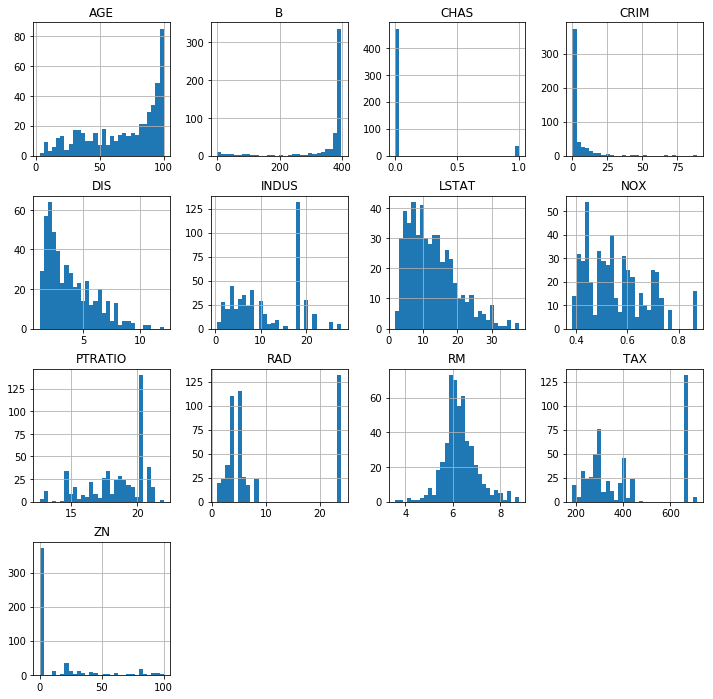

In [11]:
features.hist(bins=30, figsize=(12,12));

In [34]:
features_scale = features.copy()

In [35]:
features_scale['ZN'] = preprocessing.binarize(features_scale['ZN'].reshape(-1,1), threshold=0.0)
features_scale['AGE'] = preprocessing.quantile_transform(features_scale['AGE'].reshape(-1,1), output_distribution='normal')
features_scale['TAX'] = preprocessing.quantile_transform(features_scale['TAX'].reshape(-1,1), output_distribution='normal')
features_scale['DIS'] = features_scale['DIS'].apply(np.log)
features_scale['LSTAT'] = features_scale['LSTAT'].apply(np.log)
features_scale['PTRATIO'] = preprocessing.quantile_transform(features_scale['PTRATIO'].reshape(-1,1), output_distribution='normal')
features_scale['CRIM'] = features_scale['CRIM'].apply(np.log)
features_scale['NOX'] = features_scale['NOX'].apply(np.log1p)
features_scale['INDUS'] = features_scale['INDUS'].apply(np.log)
features_scale['B'] = preprocessing.scale(features_scale['B'])
features_scale = pd.get_dummies(features_scale, columns=['RAD'], sparse=True, drop_first=True)

C:\Users\Johnnysporto\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
C:\Users\Johnnysporto\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
C:\Users\Johnnysporto\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Johnnysporto\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


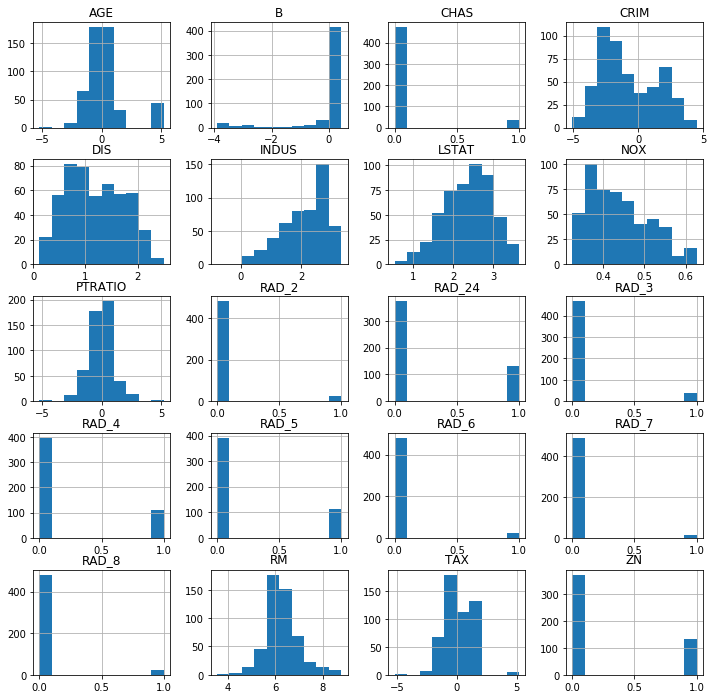

In [36]:
#features_scale['AGE'] = robust.fit_transform(features_scale['AGE'])
#features_scale[['AGE', 'B', 'CRIM', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RM', 'TAX']] = normal.fit_transform(features_scale[['AGE', 'B', 'CRIM', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RM', 'TAX']])
#features_scale[['AGE', 'B', 'CRIM', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RM', 'TAX']] = standard.fit_transform(features_scale[['AGE', 'B', 'CRIM', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RM', 'TAX']])
features_scale.hist(figsize=(12,12));

In [37]:
prices_scale = prices.copy()

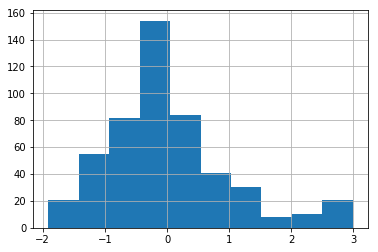

In [38]:
prices_scale = pd.Series(preprocessing.scale(prices_scale))
prices_scale.hist();

In [187]:
pprint.pprint(feature_test(features_scale))
#pprint.pprint(feature_test(features1))
#pprint.pprint(feature_test(features2))

[('B', -0.34630413544309913),
 ('CHAS', -0.22706766917293209),
 ('RM', 0.21525326580452073),
 ('LSTAT', 0.42877541850428469),
 ('PTRATIO', 0.48426110130740729),
 ('AGE', 0.50099470877330088),
 ('RAD_6', 0.57938144329896923),
 ('RAD_4', 0.64705882352941191),
 ('TAX', 0.67586425228858338),
 ('RAD_7', 0.73979591836734693),
 ('RAD_3', 0.73979591836734704),
 ('INDUS', 0.74552780433977062),
 ('RAD_2', 0.82291666666666663),
 ('NOX', 0.83289279510591441),
 ('RAD_5', 0.84888888888888892),
 ('DIS', 0.86799315604249472),
 ('CRIM', 0.9081718646761906),
 ('ZN', 0.94003527336860671),
 ('RAD_24', 0.95181861124232403),
 ('RAD_8', 1.0)]


In [39]:
X_train, X_test, y_train, y_test = split(features_scale, prices_scale)

In [176]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
model = SelectFromModel(rfr, prefit=True)
X_train_new = model.transform(X_train)

In [181]:
model.get_support(indices=True)

array([ 5, 11], dtype=int64)

In [182]:
features_scale[features_scale.columns[model.get_support()]].head()

,RM,LSTAT
0,6.575,1.605430
1,6.421,2.212660
2,7.185,1.393766
3,6.998,1.078410
4,7.147,1.673351


In [158]:
etc = ExtraTreesRegressor()
etc.fit(X_train,y_train)
model = SelectFromModel(etc, prefit=True)
X_train_new = model.transform(X_train)

In [159]:
model.get_support(indices=True)

array([ 2,  4,  5, 11, 19], dtype=int64)

In [160]:
features_scale[features_scale.columns[model.get_support()]].head()

,INDUS,NOX,RM,LSTAT,RAD_24
0,0.837248,0.430483,6.575,1.605430,0
1,1.955860,0.384582,6.421,2.212660,0
2,1.955860,0.384582,7.185,1.393766,0
3,0.779325,0.377066,6.998,1.078410,0
4,0.779325,0.377066,7.147,1.673351,0


In [167]:
lcv = LassoCV()
model = SelectFromModel(lcv, threshold=0.26)
X_train_new = model.fit_transform(X_train, y_train)
X_train_new.shape

(404L, 5L)

In [168]:
model.get_support(indices=True)

array([ 3,  4,  5,  7, 11], dtype=int64)

In [169]:
features_scale[features_scale.columns[model.get_support()]].head()

,CHAS,NOX,RM,DIS,LSTAT
0,0,0.430483,6.575,1.408545,1.605430
1,0,0.384582,6.421,1.602836,2.212660
2,0,0.384582,7.185,1.602836,1.393766
3,0,0.377066,6.998,1.802073,1.078410
4,0,0.377066,7.147,1.802073,1.673351


In [256]:
def fit_model(feat_data, feat_targ):
    # Shuffle and split the data into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(feat_data, feat_targ, test_size = 0.2, random_state = 0)
    
    reg = DecisionTreeRegressor(random_state=0)
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    return mean_squared_error(y_test, pred), reg.score(X_test, y_test)

In [258]:
fit_model(features_scale, prices_scale)

(0.44802252543394533, 0.5355202287944254)

In [19]:
%load_ext autoreload
%autoreload 2

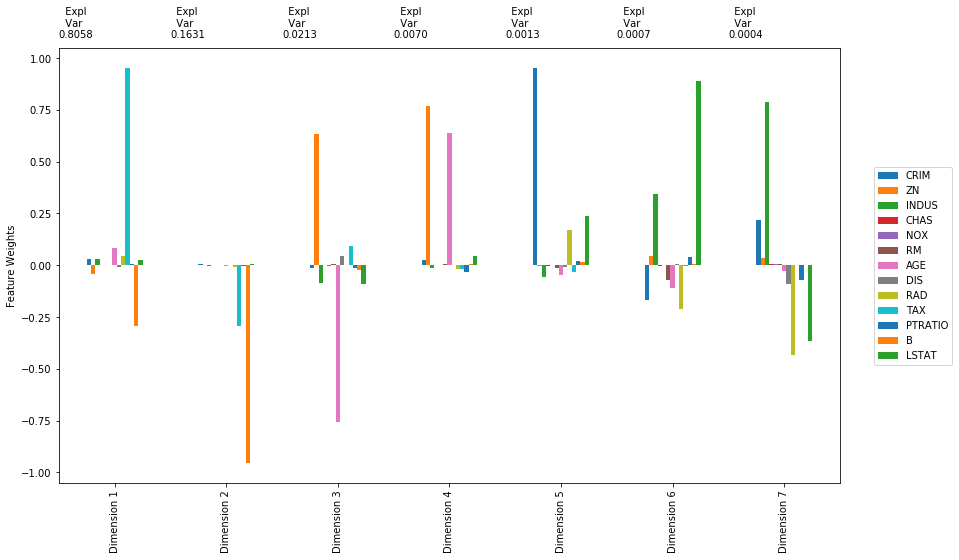

In [190]:
pca = PCA(n_components=7)
pca.fit(features)
pca_results = rs.pca_results(features, pca)

In [67]:
def performance_metric(y_true, y_predict, scorer):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = scorer(y_true, y_predict)
    
    # Return the score
    return scorer, score

In [14]:
def fit_model(X, y, scorer):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor(random_state = 0)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    max_depth = np.arange(1,11)
    params = {'max_depth': max_depth}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(scorer)

    # Create the grid search object
    grid = GridSearchCV(regressor, param_grid = params, cv = cv, scoring = scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [15]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train, mean_squared_error)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 1 for the optimal model.


In [23]:
pred = reg.predict(X_test)
scorer, score = performance_metric(pred,y_test,mean_squared_error)
print "{} score for test data set: {:.4f}".format(scorer.__name__,score)

mean_squared_error score for test data set: 61.3820


So, with minimal hyperparameter tuning. This is the result of just dumping the full dataset into the regressor without any consideration for the features or their distributions. 

This will be our baseline against which we can measure how well any feature engineering or hyperparameter tuning are performing.

The next step at this point is to start methodically selecting the features that will yield the best performance and experimenting with a variety of transformations to these features to observe the impacts on the R2 score.

One good approach to test how independent each feature is from the others is to use each feature in turn as the target to see how well the other features predict it. The idea here is that if the other features are highly correlated to it, meaning a larger positive R2 score, then that feature will be redundant and drag down performance. On the other hand if the feature has a large negative R2 score, then it is highly uncorrelated to those features and will likely make a good contribution towards predicting the dependent variable.

So, based on the results above, we can see that the lowest R2 scores are CRIM, CHAS, RM, AGE, B, and LSTAT. The best independent variable being whether the neighborhood bounds the Charles River due to the low negativity. The rest of the variables are not very to highly correlated to some one or other of the remaining features. CRIM looks to be neutral here, so that may be able to stand alone. But the rest certainly look like some combination with some of the others may be warranted.

Let's next have a look at the actual feature correlations.

From this heatmap we can see that:
- LSTAT (% of low income people) is a strong negative predictor for price, which makes sense. 
- PTRATIO (pupil-teacher ratio) is another fairly strong negative predictor - the less students per teacher the higher the price, also makes sense. 
- RM (average # of rooms per house per neighborhood) is a very strong positive predictor - bigger houses = higher prices.

Now let's see how these change when we remove some of the price outliers.

First, let's remove the price outliers that have the 666.0 TAX level. There's quite a few neighborhoods with that tax level that's doesn't seem to make sense.

There doesn't look like any sort of obvious correlations for these $50k prices. It could be that they were set for reasons not indicated in this dataset - maybe there simply was no price information for these houses at the time this data set was produced.

The first 11 neighborhoods have fairly low crime, larger, mostly older houses, that pay higher taxes, have larger populations of black people, and low percentages of lower income people. These might be considered consistent higher income neighborhoods. However, the last 5 have the highest crime, high pollution, middle to lower house sizes, the oldest homes, furtherst from highways, closest to employment centers, the highest property taxes, the highest pupil to teacher rations.

The only consistencies that can be seen here are between the median house value, the pupil to teacher ratio, the taxes per $10k, the distance to radial highways, the proportion of non-retail business acres, and the proportion of houses zoned for over 25,000 sq.ft. which are the last 5 neighborhoods on this list.

These seem to be the best candidates for removal from the dataset. We may try removing just these 5, maybe another subset, and then the whole set to see the impact on the scores.

Furthermore, as can be seen below there are 132 datapoint with TAX = 666.0, which seems like another outlier. This suggests that TAX just isn't a good feature for prediction. To remove all of these datapoints we reduce the dataset by far too much. Better to just drop this feature. We'll try this as another prediction.

Other features to consider for removal based on the table below would be PTRATIO, INDUS, and ZN due to the constancy of values suggesting some unknown correlation between them that we'd want to remove.

However, it should also be noted that Decision Tree Regressors and Random Forest Regressors are quite robust to these kinds of features definicies. So we'll be focusing on those classifiers to begin with.

For the purposes of this project, the following preprocessing steps have been made to the dataset:

- 16 data points have an 'MEDV' value of 50.0. These data points likely contain missing or censored values and have been removed.
- 1 data point has an 'RM' value of 8.78. This data point can be considered an outlier and has been removed.
- The features 'RM', 'LSTAT', 'PTRATIO', and 'MEDV' are essential. The remaining non-relevant features have been excluded.
- The feature 'MEDV' has been multiplicatively scaled to account for 35 years of market inflation.

## Analyze Model Performance

In this third section of the project, I'll take a look at a Decision Tree Regressor's learning and testing performances on various subsets of training data. Additionally, I'll investigate one particular algorithm with an increasing `max_depth` parameter on the full training set to observe how model complexity affects performance. Graphing the model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves

The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R2, the coefficient of determination.

In [5]:
import visuals as vs

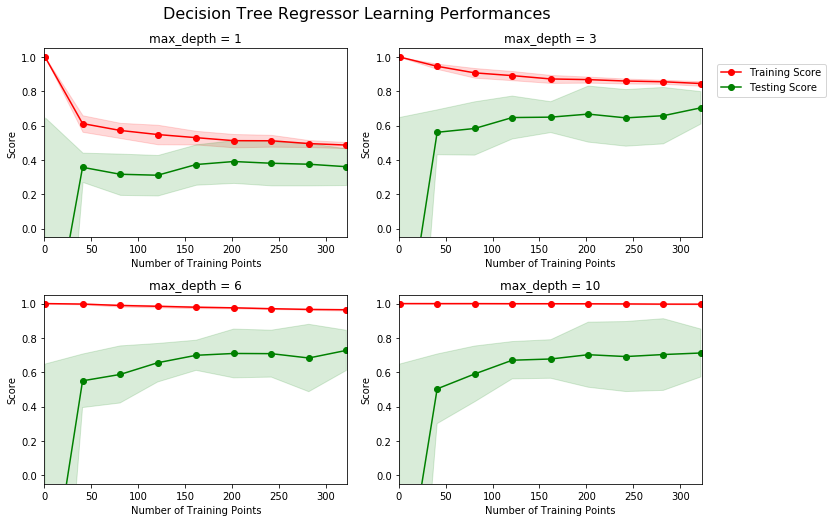

In [6]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(X_train, y_train)

## Learning the Data

Each graph above shows the number of training points used along the x-axis with the score for the model with that number of training points on the y-axis using the R2 coefficient of determination metric to evaluate it's performance.

In the first graph we see that the training and testing sets for a Decision Tree with a depth of 1 branch converge to an R2 of somewhere between 0.4 and 0.5. We also see that the training and testing models start converge around 50 data points for the training set. They get closest around 300 data points with a score of around 0.45. Because they converged so quickly, this tells us that there the model has high bias in that there isn't enough complexity in it to account for all of variation in the data, thus yielding a low score.

The graph to it's right shows the training and testing sets for a Decision tree with a maximum depth of 3 branches. Here we can see that the training and testing sets converge a bit more slowly, getting closest again near 300. However, the score is much higher at around 0.8. Also beyond this number of training points, we don't see much improvement. This appears to be a pretty good model in that there's enough complexity in the model to fit the data pretty closely, but not so much complexity that it can't account for large enough percentage of the data to yield a very score. This looks to be our best model so far.

Looking at the lower left graph for a Decision Tree with 6 branches we can see that the training data has a relatively high score near 0.9, but that the testing data seems to reach a limit at around 0.8. That lack of convergence indicates a high variance in the model in that it's too complex to account of data outside it's training data, yielding much higher discrepancies in it's training versus testing. This means it won't predict very well on new data. 

We can see that the high variance problem only gets worth with more branches in the final graph on the lower right.

So far, my best guess for the Decision Tree Regressor is to use 3 branches for an optimal model.

## Complexity Curves

The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the learning curves, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.

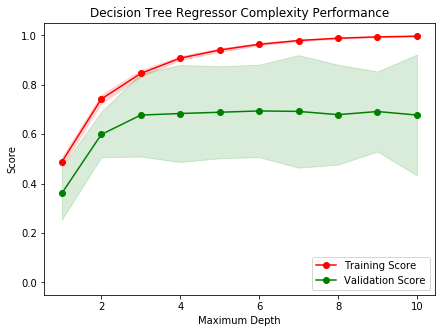

In [7]:
vs.ModelComplexity(X_train, y_train)

In the above graph we can see a validation of the Decision Tree Regressor with either 4 or 6 branches as the optimal max_depths for this data set.

## Evaluating Model Performance

Typical machine learning models have hyperparameters that are internal to the models themselves that aren't directly learned within the estimators from the datasets. Some of these models can have several hyperparameters all of which need to be independently tuned to affect the performance of the model.

Here we can use sklearn's GridSearchCV along with k-folds cross-validation to scan across various ranges of hyperparameters with varying training and testing set splits to find the best values for the highest R2 score.

When evaluating different hyperparameters for the estimators, such as the max_depth for the Decision Tree Regressor, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the held out test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

This solution to this problem is to use cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In k-fold CV, the training set is split into k smaller sets. The following procedure is followed for each of the k “folds”:

- A model is trained using k-1 of the folds as training data.
- The resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute the performance measure R2).
- This process is repeated until each subsequent kth fold has been used as the validation set, i.e. 10 subsets, 10 training cycles.
- The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but makes the best use of limited data by ensuring that every data point contributes to the training as well as the validation.

## Optimal Model

## Making Predictions

Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a decision tree regressor, the model has learned what the best questions to ask about the input data are, and can respond with a prediction for the target variable. We can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.


## Predicting Selling Prices

Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature 	| Client 1 	| Client 2  	| Client 3      |
| :-----:   | :------:  | :------:      | :------:      |
|Total number of rooms in home 	| 5 rooms |	4 rooms |	8 rooms |
|Neighborhood poverty level (as %) 	| 17% |	32% |	3% |
|Student-teacher ratio of nearby schools 	| 15-to-1 |	22-to-1 |	12-to-1 |

What price would you recommend each client sell his/her home at? Do these prices seem reasonable given the values for the respective features?

In [ ]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
pred = reg.predict(client_data)
for i, price in enumerate(pred):
    #print performance_metric(pred[i])
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

From the test data above, we can see that the house with the most number of rooms, the least amount of surrounding poverty and the lowest student-teacher ratio should have the highest price, which it does.

Conversely, the house with the least rooms, highest neighborhood poverty and highest student-teacher ration should have the lowest price, again confirmed.

The above results match our training data intuitions quite well, and confirms that relatively speaking we can expect useful results from this predictor.

## Sensitivity

An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. The code cell below will run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with the data it's trained on.

In [32]:
vs.PredictTrials(features, prices, fit_model, client_data)

NameError: name 'client_data' is not defined

## Applicability

- How relevant today is data that was collected from 1978?
- Are the features present in the data sufficient to describe a home?
- Is the model robust enough to make consistent predictions?
- Would data collected in an urban city like Boston be applicable in a rural city?

Questions like these are highly relevant to doing this type of analysis. Housing markets are extremely flexible and subject to quite a lot of variation over time that may not reflect underlying inflation in the broader economy, which is the assumption that was used to change the `MEDV`prices to reflect today's housing prices in the Boston area. So it's very likely that this data wouldn't be very robust to today's housing market in the Boston area.

Addionally, the are almost certainly other features of a house that should intuitively be more predictive of a house's value like square footage, number of bathrooms, proximity to waterfronts, number of levels, etc.

However, given those limitations, this does appear to give us a good process by which we can find good predictions with a bit more data that has more features that was more recently collected.

Finally, housing markets vary in the US quite a lot from region to region. So we should expect our model to only be predictive in the region that we modelled on.